In [1]:
from scipy.stats import gamma, multivariate_normal
from random import sample
import numpy

from matplotlib import pyplot as plot
from tqdm.notebook import tqdm
from itertools import product

%matplotlib inline

In [140]:
def distance(location, center):
    return numpy.sqrt( (location[0] - center[0]) ** 2 + (location[1] - center[1]) ** 2 )

class grid_world():
    def __init__(self, length, epochs):
        self.spaces = numpy.array(list( product( range(length), repeat = 2) ))
        self.epochs = epochs

In [141]:
class user():
    def __init__(self, world):
        self.world = world
        self.location_density = self.centered_density()        
        self.location_history = self.sample(size = world.epochs )
    
    def centered_density(self):
        inertia = numpy.random.uniform(1, 3)
        center  = self.world.spaces[ numpy.random.randint(0, len(self.world.spaces)) ]

        initial = [ numpy.random.uniform(0, 2) / (distance(L, center) + 1) for L in self.world.spaces ]
        initial = numpy.array(initial) ** inertia
        initial = numpy.round( initial / numpy.sum( initial ), decimals = 3)
        
        return initial / numpy.sum( initial )
    
    def sample(self, size = 1):
        indices = numpy.random.choice( len(self.world.spaces), p = self.location_density, size = size )
        return self.world.spaces[indices]

In [222]:
class cloaking():
    def __init__(self, epsilon):
        self.side_length = ((12 / epsilon) + 1) ** 0.25
        
    def noise(self, locations):
        locations = locations // self.side_length
        return locations * self.side_length
    
    def pdf(self, locations):
        indicators = numpy.all( locations < self.side_length, axis = 1 )
        return indicators / (self.side_length ** 2)

In [207]:
class geo_indistinguishable():
    def __init__(self, epsilon):
        self.variance = 1 / epsilon
        
    def noise(self, locations):
        return locations + self.sample_noise( locations.shape[0:2] )
    
    def sample_noise(self, size):
        theta = numpy.random.uniform(0, 2 * numpy.pi, size = size)
        r = gamma.ppf( numpy.random.uniform(0, 1, size = size), 2, scale = self.variance )        
        
        x, y = r * numpy.cos(theta), r * numpy.sin(theta)
        return numpy.stack([x, y], axis = 2)
    
    def pdf(self, locations):
        x, y = locations.T
        
        r = numpy.sqrt( x ** 2 + y ** 2)
        return gamma.pdf(r, 2, scale = self.variance) * (0.5 / numpy.pi)

In [200]:
class gaussian():
    def __init__(self, epsilon):
        self.random_variable = multivariate_normal(mean = [0, 0], cov = numpy.eye(2) / epsilon)
        
    def noise(self, locations):
        return locations + self.random_variable.rvs( size = locations.shape[:-1] )
    
    def pdf(self, locations):
        return self.random_variable.pdf( locations )

In [201]:
privacy_schemes = {
    "Gaussian": gaussian,
    "Geo-Indistinguishability": geo_indistinguishable,
    "Cloaking": cloaking
}

In [230]:
TRIALS = 1000
RADIUS = 10     # radius in kilometers

In [203]:
class server():
    def __init__(self, world, users, scheme):
        self.world, self.users, self.scheme = world, users, scheme
        
        self.locations  = numpy.array([ user.location_history for user in self.users ])
        self.heartbeats = self.scheme.noise( self.locations )
        # self.heartbeats[ user, epoch, coordinate ]
        
    def true_consensus(self, user, epoch):
        center = self.locations[user, epoch, :]
        
        timestamp = self.locations[:, epoch, :]
        distances = numpy.sqrt( numpy.sum(timestamp * timestamp, axis = 1) ).astype(int)
        return set([ i for i in range(len(distances)) if distances[i] < RADIUS ])
        
    def private_consensus(self, user, epoch):
        center = self.heartbeats[user, epoch, :]
        
        timestamp = self.heartbeats[:, epoch, :]
        distances = numpy.sqrt( numpy.sum(timestamp * timestamp, axis = 1) ).astype(int)
        return set([ i for i in range(len(distances)) if distances[i] < RADIUS ])
    
    def accuracy(self):
        instances = product( range(len(self.users)), range(self.world.epochs) )
        overlap, instances = 0, sample( list(instances), TRIALS )

        for user, epoch in instances:
            actual  = self.true_consensus(user, epoch)
            private = self.private_consensus(user, epoch)
            
            results = len(actual.intersection( private )) / (len(actual.union( private )) + 1)            
            overlap = overlap + results
        
        return overlap / TRIALS

In [204]:
class semi_honest(server):
    def inference(self, user, latest, previous):
        latest = self.heartbeats[user, latest, :]
        return previous + numpy.round( self.scheme.pdf( latest - self.world.spaces ), decimals = 10 )
    
    def timeseries_inference(self, user):
        initial = numpy.zeros(( len(self.world.spaces), ))
        estimates = [ initial ]
        
        for i in range(self.world.epochs):
            estimates.append( self.inference(user, i, estimates[i]) )
            
        estimates = estimates / numpy.sum(estimates, axis = 1)[:, None]
        return numpy.array( estimates )
    
    def bhattacharyya(self, estimate, true):
        return numpy.sum(numpy.sqrt(estimate * true), axis = 1)
    
    def average_predictive_power(self):
        predictive_power = numpy.ones(( self.world.epochs + 1, ))
        
        for user in tqdm(sample( range(len(self.users)), TRIALS ), desc = "Trials"):
            predicted = self.timeseries_inference(user)
            predictive_power = predictive_power + self.bhattacharyya(predicted, self.users[user].location_density)
        
        predictive_power = predictive_power / TRIALS
        return predictive_power

In [228]:
bay_area = grid_world(13, 335) # 18000 (~ 134^2) km^2, one week
go_bears = numpy.array([ user(bay_area) for i in tqdm(range( 70 )) ]) # 7000 thousand inhabitants

(7, 335) (7, 335) (7, 335) (7, 335)
(7, 335) (7, 335) (7, 335) (7, 335)
(7, 335) (7, 335) (7, 335) (7, 335)
(7, 335) (7, 335) (7, 335) (7, 335)
(7, 335) (7, 335) (7, 335) (7, 335)
(7, 335) (7, 335) (7, 335) (7, 335)
(7, 335) (7, 335) (7, 335) (7, 335)
(7, 335) (7, 335) (7, 335) (7, 335)
(7, 335) (7, 335) (7, 335) (7, 335)
(7, 335) (7, 335) (7, 335) (7, 335)
(7, 335) (7, 335) (7, 335) (7, 335)
(7, 335) (7, 335) (7, 335) (7, 335)
(7, 335) (7, 335) (7, 335) (7, 335)
(7, 335) (7, 335) (7, 335) (7, 335)
(7, 335) (7, 335) (7, 335) (7, 335)
(7, 335) (7, 335) (7, 335) (7, 335)
(7, 335) (7, 335) (7, 335) (7, 335)
(7, 335) (7, 335) (7, 335) (7, 335)
(7, 335) (7, 335) (7, 335) (7, 335)
(7, 335) (7, 335) (7, 335) (7, 335)



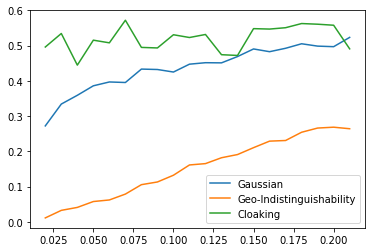

In [209]:
# TEST ACCURACY:
exogenous  = numpy.arange(0.02, 0.22, 0.01)

for name, scheme in privacy_schemes.items():
    endogenous = []
    
    for epsilon in tqdm(exogenous):
        USGS = semi_honest( bay_area, go_bears, scheme(epsilon) )
        endogenous.append( USGS.accuracy() )
    
    plot.plot(exogenous, endogenous, label = name)

plot.legend()
plot.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]



(70, 335) (70, 335) (70, 335) (70, 335)


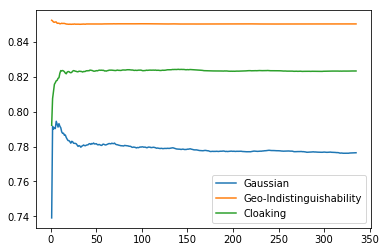

In [231]:
# TEST PRIVACY
exogenous = range(bay_area.epochs + 1)

for name, scheme in privacy_schemes.items():    
    USGS = semi_honest( bay_area, go_bears, scheme(0.02) )
    endogenous = USGS.average_predictive_power()
    
    plot.plot(exogenous, endogenous, label = name)

plot.legend()
plot.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


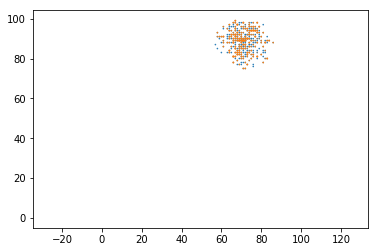

In [123]:
USGS = semi_honest( bay_area, go_bears, geo_insidt)

plot.scatter( * zip(* bay_area.spaces), s = USGS.users[0].location_density * 100 )
plot.scatter( * zip(* bay_area.spaces), s = USGS.timeseries_inference(0)[-1] * 100 )
plot.axis("equal")
plot.show()